# Librerías 

In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: c:\Users\Santiago\.pyenv\pyenv-win\versions\3.12.1\python.exe -m pip install --upgrade pip


In [2]:
import os
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.exposure import equalize_hist

from skimage.transform import integral_image
from skimage.feature import haar_like_feature, haar_like_feature_coord

import zipfile
import os

from random import sample
from skimage.transform import resize
from skimage import data, color
from sklearn.feature_extraction.image import PatchExtractor
from sklearn.metrics import precision_score, f1_score, make_scorer, accuracy_score

from sklearn.model_selection import RandomizedSearchCV, cross_validate

from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Datos

**Imágenes de rostros para entrenamiento:**
* formato .pgm
* 64 x 64 píxeles
* 0 - 255 rango de valores
* N = 12833 imágenes


**Imágenes de test (rostros y fondos sin etiquetar):**
* formato .pgm
* 19 x 19 píxeles
* 0 - 255 rango de valores
* N = 7920 imágenes 

In [3]:
# # colab
# !unzip /content/CBCL.zip
# !tar -xvzf /content/face.test.tar.gz
# !tar -xvzf /content/face.train.tar.gz

# # vscode
dataset_file = 'content/obligatorio-mlia-2024.zip'
background_file = 'content/background.zip'

dataset_extract_path = 'content/obligatorio-mlia-2024'
background_extract_path = 'content/background'

os.makedirs(background_extract_path, exist_ok=True)
os.makedirs(dataset_extract_path, exist_ok=True)

with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
    zip_ref.extractall(dataset_extract_path)

with zipfile.ZipFile(background_file, 'r') as zip_ref:
    zip_ref.extractall(background_extract_path)


# Preprocesamiento de las imágenes

In [4]:
suffix = '.pgm'

faces = os.listdir(f'{dataset_extract_path}/Faces/Faces')
faces = [filename for filename in faces if filename.endswith(suffix)]

print(f'# Faces: {len(faces)}')


# Faces: 12833


## Obtención de rostros para entrenamiento

In [5]:
# Tamaño de las imágenes de rostros
size = (19,19)

def get_faces_subset(n_faces):
    sample_faces = sample(faces, n_faces)

    im_faces = []
    for filename in tqdm(sample_faces):
        path = f'{dataset_extract_path}/Faces/Faces/' + filename
        with open(path, 'rb') as pgmf:
            image = plt.imread(pgmf)
            image = resize(image, size)
        im_faces.append(image)
    return im_faces


In [6]:
n_faces_subset_one = 1000
im_faces = get_faces_subset(n_faces_subset_one)

100%|██████████| 1000/1000 [00:03<00:00, 319.43it/s]


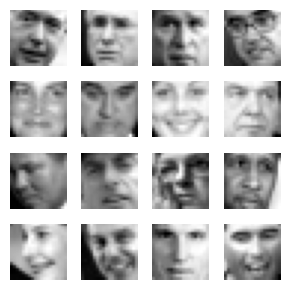

In [7]:
# Visualización de las imágenes de rostros
K = 16
indices = sample(range(n_faces_subset_one),k=K)

fig, ax = plt.subplots(4, 4, figsize=(3, 3), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(K):
    idx = indices[i]
    image = im_faces[idx]
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

## Obtención de fondos para entrenamiento

In [8]:
# Tomamos algunas imágenes de sklearn
imgs_skimage = ['text',
                'coins',
                'moon',
                'page',
                'clock',
                'immunohistochemistry',
                'chelsea',
                'coffee',
                'hubble_deep_field'
                ]

backgrounds_big = []
for name in imgs_skimage:
    image = getattr(data, name)()
    if len(image.shape) == 3 and image.shape[2] == 3:  # Chequeamos si la imagen es RGB
        image = color.rgb2gray(image)
    backgrounds_big.append(image)

# Imagenes de fondo adicionales
for i in range(31):
    filename = f'{background_extract_path}/' + str(i) + '.jpg'
    image = plt.imread(filename)
    image = color.rgb2gray(image)
    backgrounds_big.append(image)

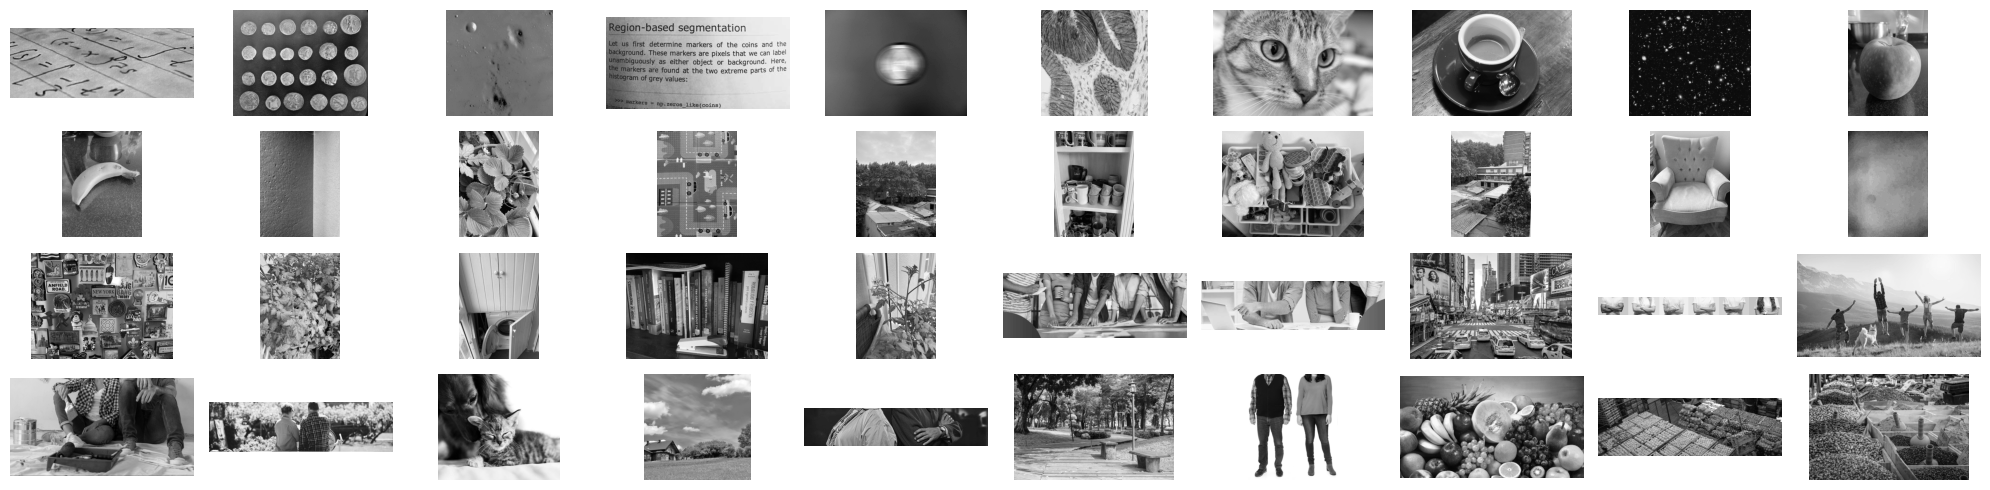

In [9]:
# Visualización de las imágenes de fondos
fig, ax = plt.subplots(4, 10, figsize=(20, 5), subplot_kw=dict(xticks=[], yticks=[]))
axes = ax.ravel()

for i in range(len(backgrounds_big)):
    image = backgrounds_big[i]
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()

In [10]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size=size, random_state=0):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    H = img.shape[0]
    W = img.shape[1]
    H_patch = min(H , int(scale * patch_size[0]))
    W_patch = min(W , int(scale * patch_size[1]))
    extracted_patch_size = (H_patch, W_patch)

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=random_state)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches


In [11]:
def get_backgrounds_subset(proportion, n_faces):
    # Extraer parches de las imágenes de fondo
    scales = [1,1.5,2,2.5]

    num_patches = int((proportion * n_faces)/(len(scales) * len(backgrounds_big)))

    im_backgrounds = np.vstack(
        [extract_patches(im_bkgnd, num_patches, scale, random_state=42)
        for im_bkgnd in tqdm(backgrounds_big)
        for scale in scales]
        )
    return im_backgrounds

In [12]:

im_backgrounds = get_backgrounds_subset(3, n_faces_subset_one)

print(f'# Back: {len(im_backgrounds)}')

100%|██████████| 40/40 [00:00<00:00, 162.01it/s]

# Back: 2880


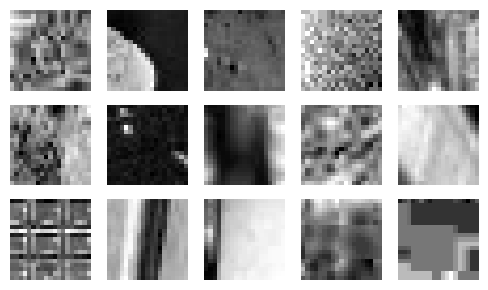

In [13]:
# Visualización de una muestra
fig, ax = plt.subplots(3, 5, figsize=(5,3))
for i, axi in enumerate(ax.flat):
    axi.imshow(im_backgrounds[100 * i], cmap='gray')
    axi.axis('off')
plt.tight_layout()
plt.show()

In [14]:
im_faces = np.array(im_faces)

print(f'Faces shape: {im_faces.shape}')
print(f'Backgrounds shape: {im_backgrounds.shape}')

Faces shape: (1000, 19, 19)
Backgrounds shape: (2880, 19, 19)


## Obtención de datos para entrenamiento (subset 1)

In [15]:
Im_train = np.vstack([im_faces, im_backgrounds])
print(f'Images shape: {Im_train.shape}')

Images shape: (3880, 19, 19)


In [16]:
y_train = np.array([1]*len(im_faces)+[0]*len(im_backgrounds))
print(f'y_train shape: {y_train.shape}')

y_train shape: (3880,)


## Normalización de las imágenes de entrenamiento

In [17]:
# Normalización de las imágenes de entrenamiento
Im_train_norm = [equalize_hist(image) for image in Im_train]

## Extracción de features

In [18]:
def extract_feature_image(img, feature_type=None, feature_coord=None):
    """Extrae las Haar features de la imagen"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)

##  Transformación de las imágenes de entrenamiento

In [19]:
X_train = [extract_feature_image(img) for img in tqdm(Im_train_norm)]
# Matriz de features
X_train = np.array(X_train)

100%|██████████| 3880/3880 [03:26<00:00, 18.82it/s]


In [20]:
# Guardar la matriz 
np.save('X_train', X_train)

In [21]:
# Cargar la matriz
X_train = np.load('X_train.npy')

In [22]:
X_train.shape

(3880, 63960)

# Clasificadores

## Evaluación, selección de features y búsqueda de hiperparámetros

In [23]:
def classifierOptimizer(classifier_name, X_train, y_train, param_dist, classifier):
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score),
        'f1': make_scorer(f1_score, average='binary')
    }

    random_search = RandomizedSearchCV(estimator=classifier,
                                    param_distributions=param_dist,
                                    n_iter=25,
                                    cv=2,
                                    scoring=scoring,
                                    refit='f1',
                                    verbose=3,
                                    n_jobs=8)

    random_search.fit(X_train, y_train)
    cv_results = random_search.cv_results_
    best_model = random_search.best_estimator_

    # Obtener la importancia de las features del mejor modelo
    features_indexes = None
    if classifier_name == 'Logistic Regression':
        feature_importances = best_model.coef_[0]
        # Seleccionar las 200 mejores features
        features_indexes = np.argsort(np.abs(feature_importances))[-200:]
    elif classifier_name == 'Neural Network':
        feature_importances = np.abs(best_model.coefs_[0]).sum(axis=1)
        features_indexes = np.argsort(feature_importances)[-200:]
    else:
        feature_importances = best_model.feature_importances_
        features_indexes = np.argsort(feature_importances)[-200:]

    # Imprimir los resultados del F1 score para cada iteración
    cv_results = random_search.cv_results_

    best_results = {
        'f1': cv_results['mean_test_f1'][random_search.best_index_],
        'accuracy': cv_results['mean_test_accuracy'][random_search.best_index_],
        'precision': cv_results['mean_test_precision'][random_search.best_index_],
        'params': cv_results['params'][random_search.best_index_]
    }

    print("============================================================")
    print(f"Iteración con mejor F1 Score para {classifier_name}:")
    print("============================================================\n")
    print("Modelo:", best_model)
    print("Hiperparámetros:", random_search.best_params_)
    print(f"Accuracy: {best_results['accuracy']}")
    print(f"Precision: {best_results['precision']}")
    print(f"F1 Score: {best_results['f1']}")
    print("------------------------------------------------------------")

    params_df = pd.json_normalize(cv_results['params'])
    results_dataframe = pd.DataFrame({
        'accuracy': cv_results['mean_test_accuracy'],
        'precision': cv_results['mean_test_precision'],
        'f1_score': cv_results['mean_test_f1']
    })
    results_dataframe = pd.concat([results_dataframe, params_df], axis=1)
    results_dataframe.index.name = 'Iteration'
    results_dataframe.to_csv(f'FirstTrainResults/{classifier_name}_results.csv')

    best_index = random_search.best_index_

    return best_model, features_indexes, best_results, results_dataframe, cv_results, best_index


In [24]:
def plot_metric_score_results(results_dataframe, best_iteration, metric_name, metric):
    fig, ax = plt.subplots()
    
    colors = ['blue'] * len(results_dataframe)
    colors[best_iteration] = 'red'
    
    ax.plot(results_dataframe.index, results_dataframe[metric], marker='o', color='blue', linestyle='-', markersize=5)
    
    # Resaltar el mejor punto
    ax.plot(results_dataframe.index[best_iteration], results_dataframe[metric][best_iteration], marker='o', color='red', markersize=6)
    
    # Etiquetar el mejor punto
    ax.annotate(f'{results_dataframe[metric][best_iteration]:.4f}', 
                (results_dataframe.index[best_iteration], results_dataframe[metric][best_iteration]), 
                textcoords="offset points", xytext=(20, 4), ha='center', color='red')

    ax.set_title(f'{metric_name} por Iteración')
    ax.set_xlabel('Iteración')
    ax.set_ylabel(metric_name)
    plt.xticks(rotation=45)
    
    plt.show()

### Random Forest - Ronda 1 de entrenamiento (subset 1)

In [25]:
param_dist_rf = {
        'n_estimators': randint(50, 200),
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

best_rf_model, features_indexes_rf, best_rf_results, results_dataframe_rf, cv_results_rf, best_index_rf = classifierOptimizer("Random Forest", X_train, y_train, param_dist_rf, RandomForestClassifier(random_state=42))


Fitting 2 folds for each of 25 candidates, totalling 50 fits
Iteración con mejor F1 Score para Random Forest:

Modelo: RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       min_samples_split=6, n_estimators=199, random_state=42)
Hiperparámetros: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 199}
Accuracy: 0.9806701030927836
Precision: 0.9782333413190047
F1 Score: 0.9618258737123314
------------------------------------------------------------


In [26]:
results_dataframe_rf

,accuracy,precision,f1_score,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators
Iteration,,,,,,,,,
0,0.974227,0.977714,0.948509,True,20.0,log2,2,5,87
1,0.979381,0.977154,0.959229,False,10.0,sqrt,2,3,153
2,0.978866,0.977125,0.958137,False,NaN,sqrt,3,9,126
3,0.976289,0.973853,0.952938,True,30.0,sqrt,4,5,173
4,0.975515,0.981918,0.951003,True,20.0,log2,4,2,195
5,0.975773,0.985011,0.951396,True,NaN,log2,3,7,99
6,0.975258,0.976845,0.950726,False,NaN,log2,2,5,64
7,0.977577,0.983084,0.955264,False,10.0,log2,3,2,189
8,0.977835,0.981065,0.955894,False,NaN,log2,2,3,139


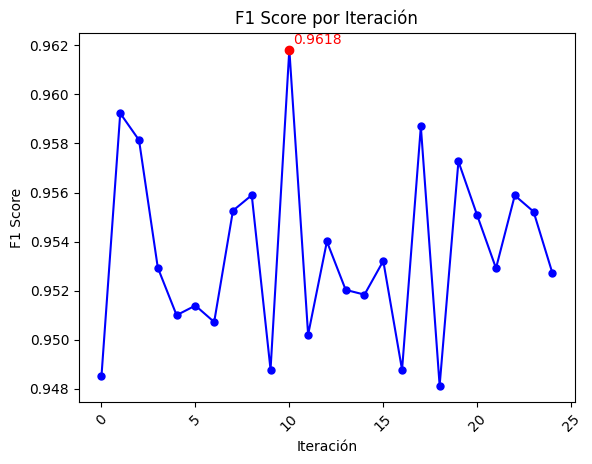

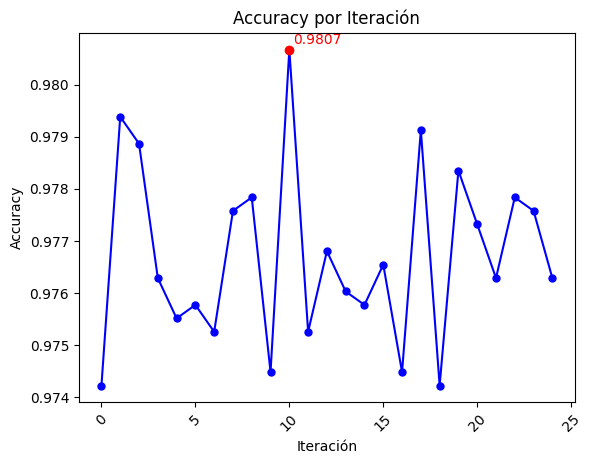

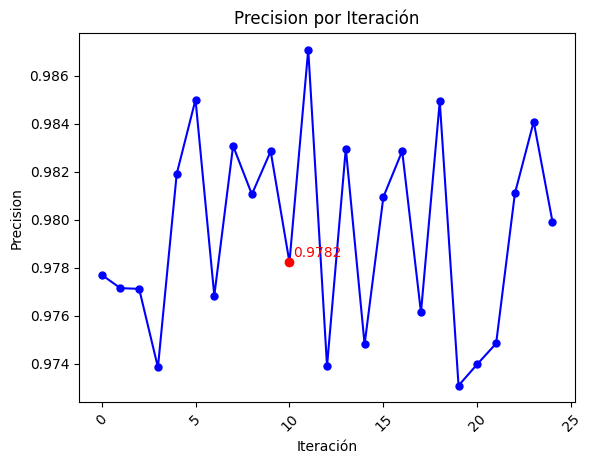

In [27]:
plot_metric_score_results(results_dataframe_rf, best_index_rf, 'F1 Score', 'f1_score')
plot_metric_score_results(results_dataframe_rf, best_index_rf, 'Accuracy', 'accuracy')
plot_metric_score_results(results_dataframe_rf, best_index_rf, 'Precision', 'precision')

### Gradient Boosting - Ronda 1 de entrenamiento (subset 1)

In [28]:
params_dist_gb = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.01, 0.1, 0.05, 0.001],
    'max_depth': [3, 4, 5, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'subsample': [0.8, 0.9, 1.0]
}

best_gb_model, features_indexes_gb, best_gb_results, results_dataframe_gb, cv_results_gb, best_index_gb = classifierOptimizer("Gradient Boosting", X_train, y_train, params_dist_gb, GradientBoostingClassifier(random_state=42))

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Iteración con mejor F1 Score para Gradient Boosting:

Modelo: GradientBoostingClassifier(max_depth=4, max_features='log2', min_samples_leaf=4,
                           min_samples_split=6, n_estimators=149,
                           random_state=42, subsample=0.9)
Hiperparámetros: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 149, 'subsample': 0.9}
Accuracy: 0.9853092783505155
Precision: 0.9896156832298137
F1 Score: 0.9709604085784873
------------------------------------------------------------


In [29]:
results_dataframe_gb

,accuracy,precision,f1_score,learning_rate,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,subsample
Iteration,,,,,,,,,,
0,0.985309,0.989616,0.970960,0.100,4,log2,4,6,149,0.9
1,0.979381,0.982182,0.959058,0.100,20,log2,4,9,94,0.8
2,0.973969,0.989187,0.947337,0.050,10,log2,3,2,51,1.0
3,0.742268,0.000000,0.000000,0.001,30,sqrt,2,2,176,0.9
4,0.976546,0.977917,0.953356,0.050,4,log2,4,5,78,0.8
5,0.967268,0.996598,0.932391,0.010,30,sqrt,1,5,94,1.0
6,0.978608,0.984159,0.957370,0.100,30,log2,1,8,141,1.0
7,0.894330,1.000000,0.742136,0.010,20,log2,3,6,51,0.9
8,0.968814,0.981346,0.936710,0.010,3,sqrt,3,6,143,0.8


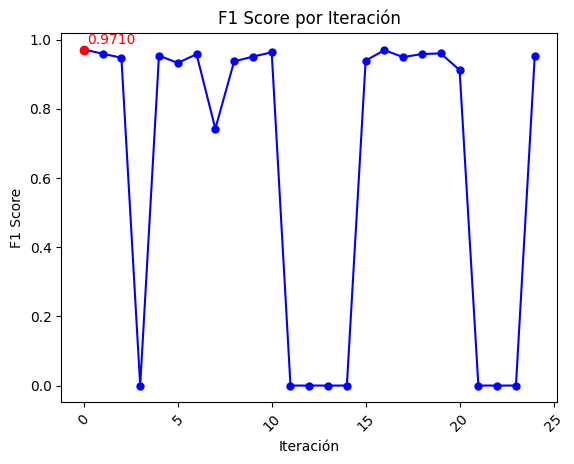

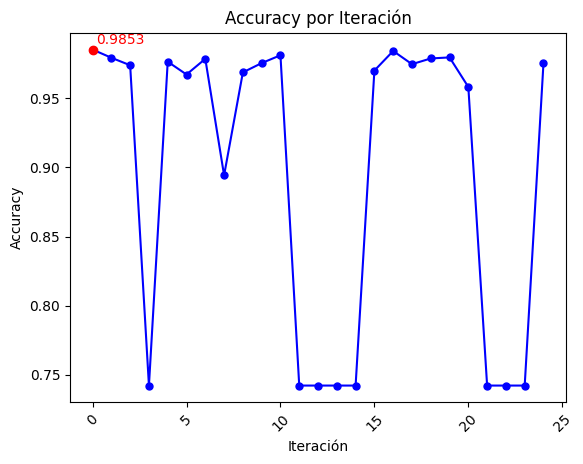

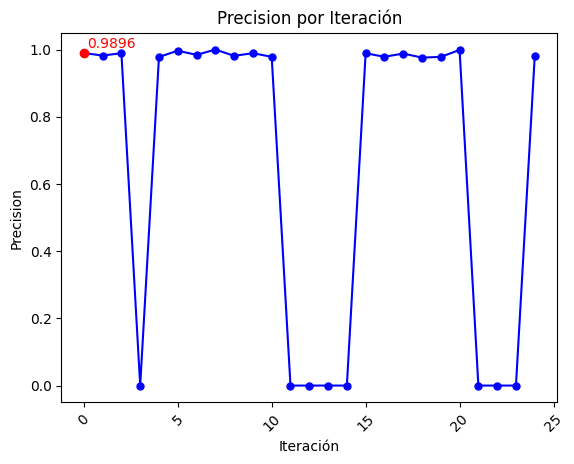

In [30]:
plot_metric_score_results(results_dataframe_gb, best_index_gb, 'F1 Score', 'f1_score')
plot_metric_score_results(results_dataframe_gb, best_index_gb, 'Accuracy', 'accuracy')
plot_metric_score_results(results_dataframe_gb, best_index_gb, 'Precision', 'precision')

### Árboles de decisión - Ronda 1 de entrenamiento (subset 1)

In [31]:
params_dist_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}

best_dt_model, features_indexes_dt, best_dt_results, results_dataframe_dt, cv_results_dt, best_index_dt = classifierOptimizer("Decision Tree", X_train, y_train, params_dist_dt, DecisionTreeClassifier(random_state=42))

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Iteración con mejor F1 Score para Decision Tree:

Modelo: DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=3,
                       random_state=42)
Hiperparámetros: {'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
Accuracy: 0.9528350515463917
Precision: 0.8995580808080808
F1 Score: 0.9094274876327161
------------------------------------------------------------


In [32]:
results_dataframe_dt

,accuracy,precision,f1_score,criterion,max_depth,max_features,min_samples_leaf,min_samples_split
Iteration,,,,,,,,
0,0.934536,0.880701,0.871753,gini,NaN,sqrt,1,9
1,0.952577,0.895707,0.909325,entropy,20.0,None,1,2
2,0.918041,0.861977,0.836242,gini,10.0,log2,4,4
3,0.944072,0.879872,0.893183,gini,30.0,None,1,2
4,0.938402,0.893486,0.878495,entropy,NaN,sqrt,4,4
5,0.939948,0.868897,0.885973,gini,30.0,None,1,5
6,0.904897,0.820053,0.814358,gini,10.0,log2,2,4
7,0.944072,0.879872,0.893183,gini,30.0,None,1,3
8,0.931443,0.867794,0.866853,entropy,10.0,log2,3,2


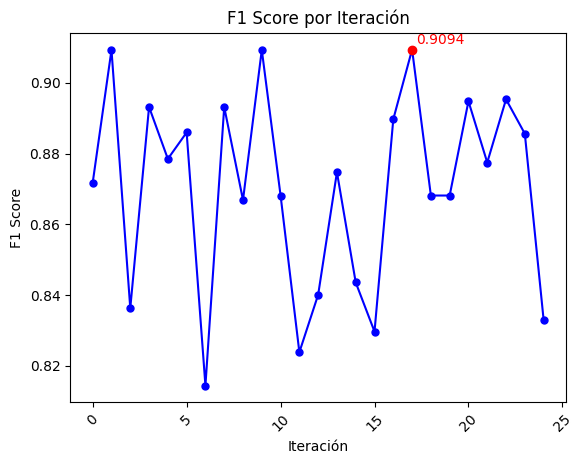

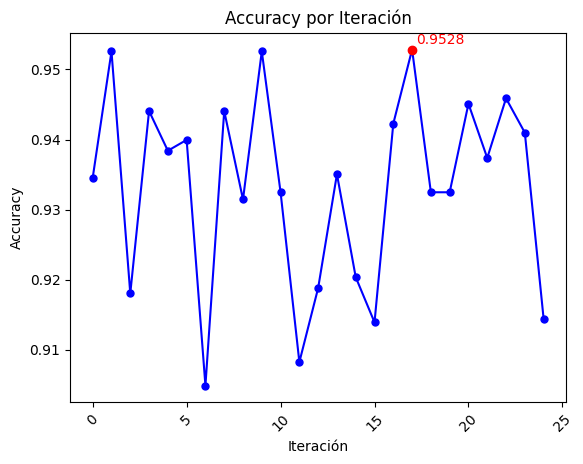

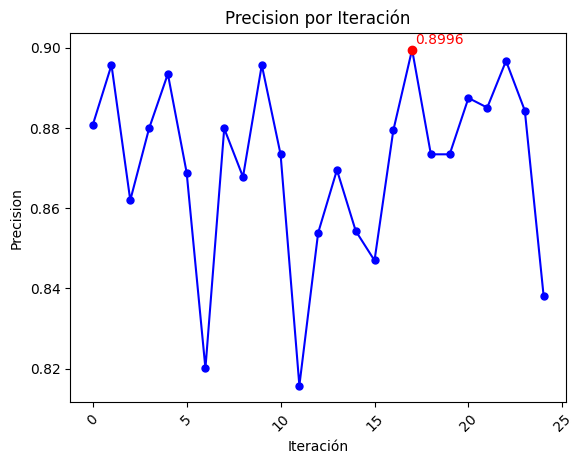

In [33]:
plot_metric_score_results(results_dataframe_dt, best_index_dt, 'F1 Score', 'f1_score')
plot_metric_score_results(results_dataframe_dt, best_index_dt, 'Accuracy', 'accuracy')
plot_metric_score_results(results_dataframe_dt, best_index_dt, 'Precision', 'precision')

### Regresión logística - Ronda 1 de entrenamiento (subset 1)

In [34]:
params_dist_lr = {
    'loss': ['log_loss'],  # Solo para regresión logística
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': uniform(0.0001, 0.001),
    'max_iter': randint(1000, 2000),
    'tol': [1e-3, 1e-4, 1e-5],
}

best_lr_model, features_indexes_lr, best_lr_results, results_dataframe_lr, cv_results_lr, best_index_lr = classifierOptimizer("Logistic Regression", X_train, y_train, params_dist_lr, SGDClassifier(random_state=42))

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Iteración con mejor F1 Score para Logistic Regression:

Modelo: SGDClassifier(alpha=0.00013498577581854635, loss='log_loss', max_iter=1148,
              penalty='l1', random_state=42, tol=0.0001)
Hiperparámetros: {'alpha': 0.00013498577581854635, 'loss': 'log_loss', 'max_iter': 1148, 'penalty': 'l1', 'tol': 0.0001}
Accuracy: 0.9747422680412371
Precision: 0.9537223340040242
F1 Score: 0.9508525576730191
------------------------------------------------------------


In [35]:
results_dataframe_lr

,accuracy,precision,f1_score,alpha,loss,max_iter,penalty,tol
Iteration,,,,,,,,
0,0.972680,0.966757,0.945837,0.000498,log_loss,1038,l2,0.00100
1,0.967268,0.961215,0.934792,0.001065,log_loss,1958,elasticnet,0.00001
2,0.972680,0.966757,0.945837,0.000249,log_loss,1275,l2,0.00001
3,0.972680,0.966757,0.945837,0.000509,log_loss,1499,l2,0.00100
4,0.974742,0.953722,0.950853,0.000135,log_loss,1148,l1,0.00010
5,0.967526,0.942602,0.936520,0.000984,log_loss,1354,l2,0.00010
6,0.969072,0.945814,0.939622,0.001011,log_loss,1027,l2,0.00010
7,0.971392,0.945060,0.944501,0.000706,log_loss,1685,l1,0.00010
8,0.956701,0.987119,0.909385,0.001061,log_loss,1976,l2,0.00001


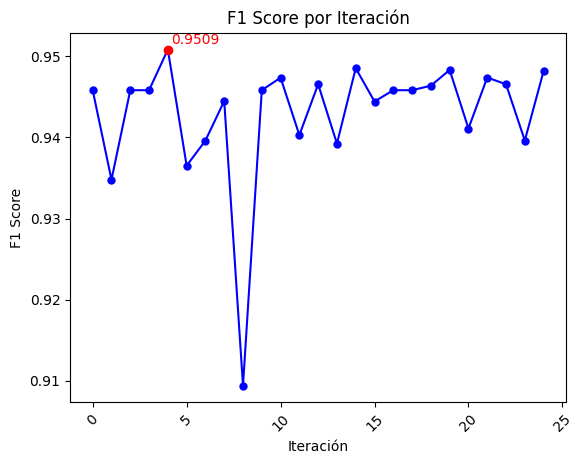

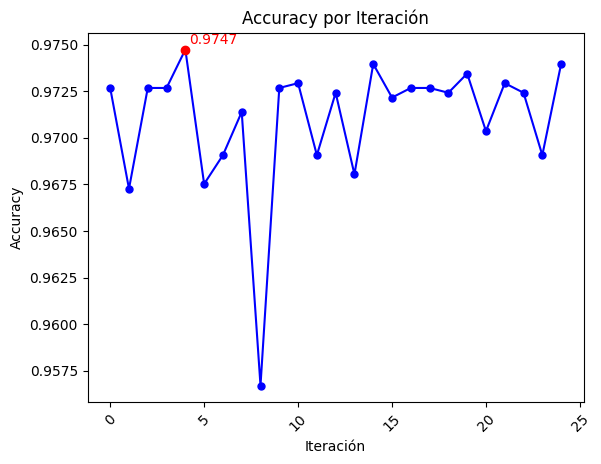

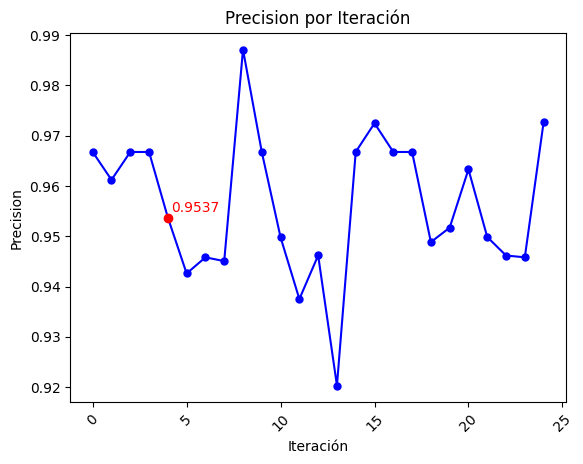

In [36]:
plot_metric_score_results(results_dataframe_lr, best_index_lr, 'F1 Score', 'f1_score')
plot_metric_score_results(results_dataframe_lr, best_index_lr, 'Accuracy', 'accuracy')
plot_metric_score_results(results_dataframe_lr, best_index_lr, 'Precision', 'precision')

### Redes Neuronales - Ronda 1 de entrenamiento (subset 1)

In [37]:
params_dist_mlp = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': uniform(0.0001, 0.001),
    'learning_rate': ['constant','adaptive'],
    'max_iter': randint(1000, 2000)
}

best_mlp_model, features_indexes_mlp, best_mlp_results, results_dataframe_mlp, cv_results_mlp, best_index_mlp = classifierOptimizer("Neural Network", X_train, y_train, params_dist_mlp, MLPClassifier(random_state=42))

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Iteración con mejor F1 Score para Neural Network:

Modelo: MLPClassifier(alpha=0.0009746734781355031, hidden_layer_sizes=(50, 100, 50),
              max_iter=1316, random_state=42)
Hiperparámetros: {'activation': 'relu', 'alpha': 0.0009746734781355031, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'max_iter': 1316, 'solver': 'adam'}
Accuracy: 0.9791237113402061
Precision: 0.9590738877710709
F1 Score: 0.9595249893105612
------------------------------------------------------------


In [38]:
results_dataframe_mlp

,accuracy,precision,f1_score,activation,alpha,hidden_layer_sizes,learning_rate,max_iter,solver
Iteration,,,,,,,,,
0,0.855670,0.462355,0.470530,relu,0.000490,"(50, 50, 50)",constant,1349,sgd
1,0.968041,0.934517,0.938462,relu,0.000450,"(100,)",adaptive,1806,adam
2,0.964175,0.948562,0.929019,tanh,0.000754,"(50, 100, 50)",constant,1798,sgd
3,0.810825,0.477740,0.352273,tanh,0.000973,"(50, 50, 50)",adaptive,1385,adam
4,0.968814,0.916107,0.941650,relu,0.000548,"(50, 100, 50)",constant,1291,adam
5,0.838660,0.427083,0.438716,tanh,0.000889,"(50, 50, 50)",adaptive,1872,adam
6,0.856701,0.468504,0.472222,relu,0.000916,"(50, 50, 50)",adaptive,1224,sgd
7,0.807216,0.846939,0.398643,tanh,0.000515,"(50, 50, 50)",adaptive,1013,adam
8,0.944845,0.888409,0.895030,tanh,0.000735,"(100,)",constant,1893,adam


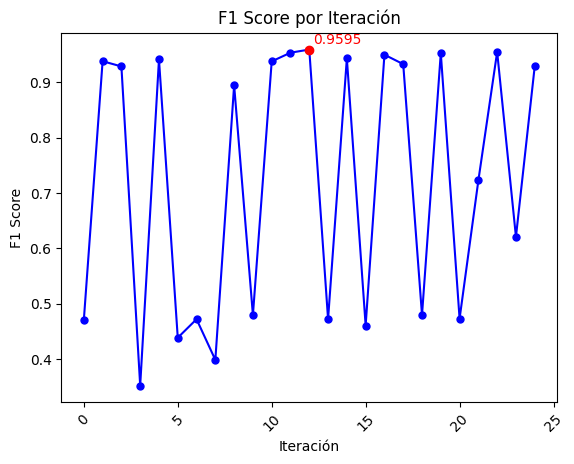

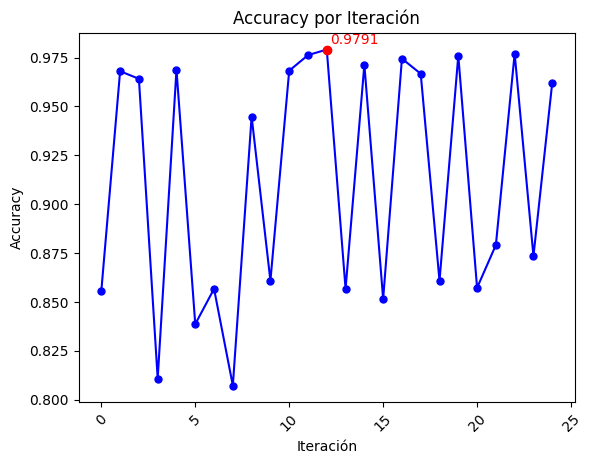

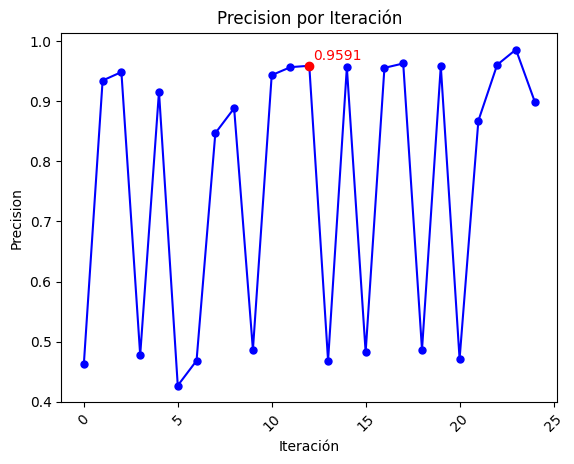

In [39]:
plot_metric_score_results(results_dataframe_mlp, best_index_mlp, 'F1 Score', 'f1_score')
plot_metric_score_results(results_dataframe_mlp, best_index_mlp, 'Accuracy', 'accuracy')
plot_metric_score_results(results_dataframe_mlp, best_index_mlp, 'Precision', 'precision')

## Selección de modelos

### Obtención de datos para entrenamiento (subset 2)

In [40]:
n_faces_subset_two = 5000
im_faces_two = get_faces_subset(n_faces_subset_two)

im_backgrounds_two = get_backgrounds_subset(3, n_faces_subset_two)

100%|██████████| 40/40 [00:00<00:00, 43.91it/s]


In [41]:
im_faces_two = np.array(im_faces_two)

print(f'Faces shape: {im_faces_two.shape}')
print(f'Backgrounds shape: {im_backgrounds_two.shape}')

Faces shape: (5000, 19, 19)
Backgrounds shape: (14880, 19, 19)


In [42]:
Im_train_two = np.vstack([im_faces_two, im_backgrounds_two])
print(f'Images shape: {Im_train_two.shape}')

Images shape: (19880, 19, 19)


In [43]:
y_train_two = np.array([1]*len(im_faces_two)+[0]*len(im_backgrounds_two))
print(f'y_train_two shape: {y_train_two.shape}')

y_train_two shape: (19880,)


In [44]:
Im_train_norm_two = [equalize_hist(image) for image in Im_train_two]

In [45]:
X_train_two = [extract_feature_image(img) for img in tqdm(Im_train_norm_two)]
# Matriz de features
X_train_two = np.array(X_train_two)

100%|██████████| 19880/19880 [28:15<00:00, 11.72it/s]


### Evaluación según F1 score (subset 2)

In [46]:
# Evaluar y obtener F1 scores
f1_scorer = make_scorer(f1_score, average='binary')
accuracy_scorer = make_scorer(accuracy_score)
precision_scorer = make_scorer(precision_score)

def evaluate_model(model, X_train, y_train, cv=2):
    # Utilizar cross_validate para calcular varias métricas
    scoring = {
        'f1': f1_scorer,
        'accuracy': accuracy_scorer,
        'precision': precision_scorer
    }
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

    # Mostrar los resultados
    print("============================================================")
    print(f"Metrics scores for {model.__class__.__name__}: \n")
    print("============================================================\n")
    print(f"F1 score: {scores['test_f1'].mean()}")
    print(f"Accuracy score: {scores['test_accuracy'].mean()}")
    print(f"Precision score: {scores['test_precision'].mean()}")
    print("------------------------------------------------------------")

    return scores

#### Random Forest - Ronda 2 de entrenamiento (subset 2)

In [47]:
scores_rf = evaluate_model(best_rf_model, X_train_two[:, features_indexes_rf], y_train_two)

Metrics scores for RandomForestClassifier: 


F1 score: 0.9589408104513288
Accuracy score: 0.9794265593561369
Precision score: 0.9630308643803127
------------------------------------------------------------


#### Gradient Boosting - Ronda 2 de entrenamiento (subset 2)

In [48]:
scores_gb = evaluate_model(best_gb_model, X_train_two[:, features_indexes_gb], y_train_two)

Metrics scores for GradientBoostingClassifier: 


F1 score: 0.972667627130272
Accuracy score: 0.986317907444668
Precision score: 0.977035685782693
------------------------------------------------------------


#### Árboles de decisión - Ronda 2 de entrenamiento (subset 2)

In [49]:
scores_dt = evaluate_model(best_dt_model, X_train_two[:, features_indexes_dt], y_train_two)

Metrics scores for DecisionTreeClassifier: 


F1 score: 0.9315719600885173
Accuracy score: 0.9655935613682092
Precision score: 0.9319460850749658
------------------------------------------------------------


#### Regresión logística - Ronda 2 de entrenamiento (subset 2)

In [50]:
scores_lr = evaluate_model(best_lr_model, X_train_two[:, features_indexes_lr], y_train_two)

Metrics scores for SGDClassifier: 


F1 score: 0.952322259722498
Accuracy score: 0.9760060362173039
Precision score: 0.9519354237990864
------------------------------------------------------------


#### Redes Neuronales - Ronda 2 de entrenamiento (subset 2)

In [51]:
scores_mlp = evaluate_model(best_mlp_model, X_train_two[:, features_indexes_mlp], y_train_two)

Metrics scores for MLPClassifier: 


F1 score: 0.9151206851807965
Accuracy score: 0.9573943661971831
Precision score: 0.9179015000867401
------------------------------------------------------------


# Modelo final

## Gráficas comparativas

In [52]:
# Graficar los resultados de las metricas del 1er y 2do entrenamiento
def plot_metrics_results_comparison(metric_label, metric_name_first_stage, metric_name_second_stage):
    # Metricas de la primera etapa de entrenamiento
    metrics_results_first_stage = {
        "Random Forest": best_rf_results[metric_name_first_stage],
        "Gradient Boosting": best_gb_results[metric_name_first_stage],
        "Decision Tree": best_dt_results[metric_name_first_stage],
        "Logistic Regression": best_lr_results[metric_name_first_stage],
        "Neural Network": best_mlp_results[metric_name_first_stage]
    }

    # Metricas de la segunda etapa de entrenamiento
    metrics_results_second_stage = {
        "Random Forest": scores_rf[metric_name_second_stage].mean(),
        "Gradient Boosting": scores_gb[metric_name_second_stage].mean(),
        "Decision Tree": scores_dt[metric_name_second_stage].mean(),
        "Logistic Regression": scores_lr[metric_name_second_stage].mean(),
        "Neural Network": scores_mlp[metric_name_second_stage].mean()
    }

    # Nombres de los modelos y los scores
    models = list(metrics_results_first_stage.keys())
    first_stage_scores = list(metrics_results_first_stage.values())
    second_stage_scores = list(metrics_results_second_stage.values())

    x = np.arange(len(models))  
    width = 0.35  

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, first_stage_scores, width, label='Primera Etapa de Entrenamiento', color='skyblue')
    rects2 = ax.bar(x + width/2, second_stage_scores, width, label='Segunda Etapa de Entrenamiento', color='darkblue')

    ax.set_xlabel('Modelo')
    ax.set_ylabel(metric_label)
    ax.set_title(f'Comparación de {metric_label} entre la primera y segunda etapa de entrenamiento')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=20)
    ax.legend(loc='lower right')

    # Labels para las barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 3)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 1),  
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

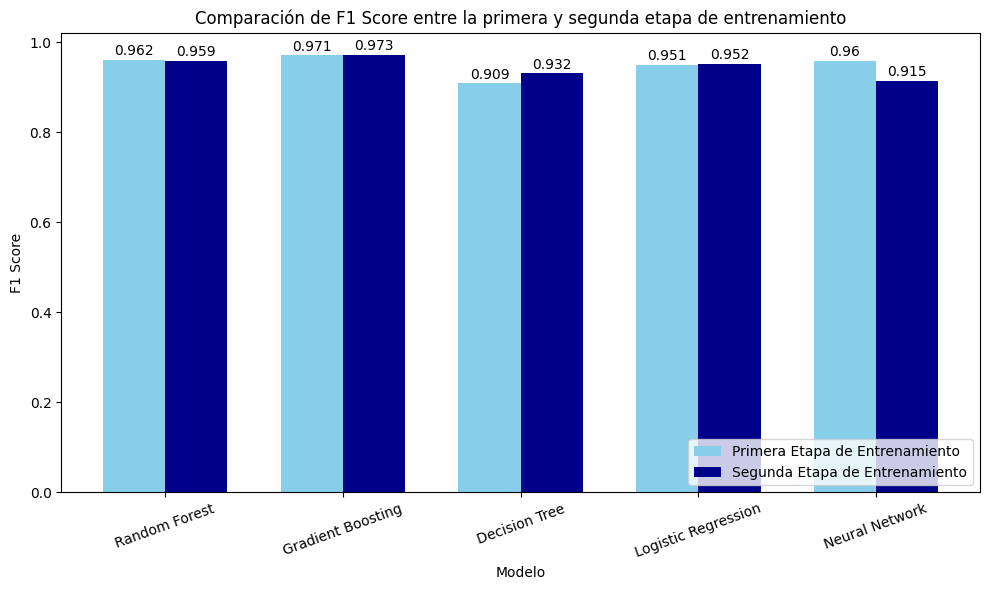

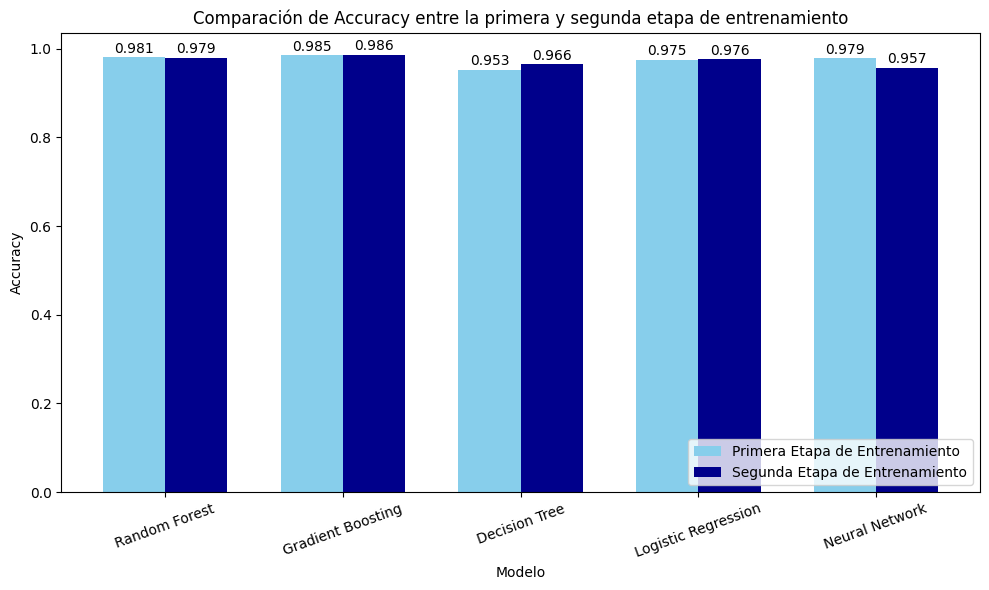

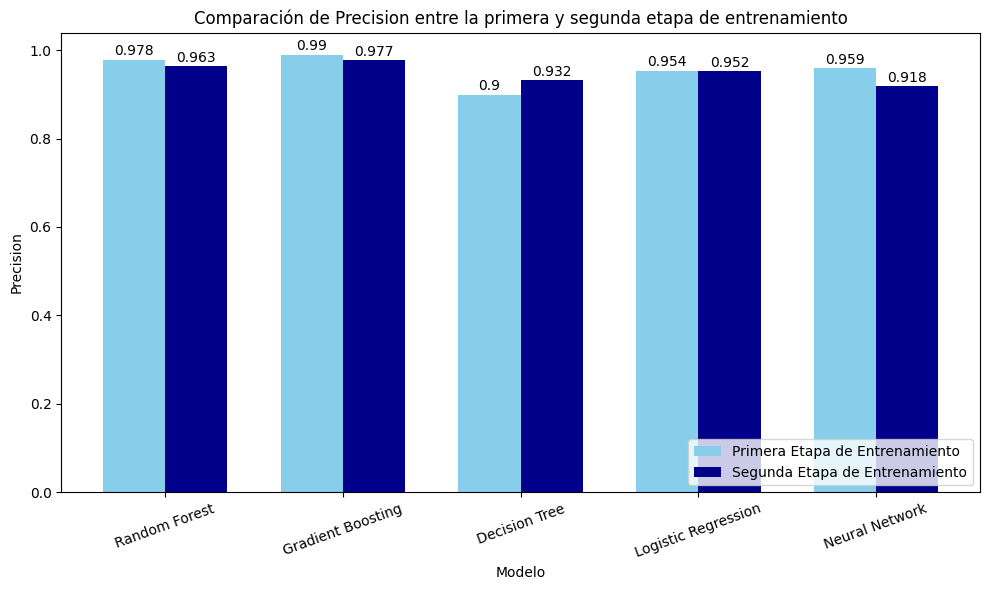

In [53]:
plot_metrics_results_comparison('F1 Score', 'f1', 'test_f1')
plot_metrics_results_comparison('Accuracy', 'accuracy', 'test_accuracy')
plot_metrics_results_comparison('Precision', 'precision', 'test_precision')

## Tablas comparativas

In [54]:
# Imprimir F1 score, accuracy y precision de la segunda etapa de entrenamiento para todos los modelos
data = {
    'F1 Score': [
        scores_rf['test_f1'].mean(),
        scores_gb['test_f1'].mean(),
        scores_dt['test_f1'].mean(),
        scores_lr['test_f1'].mean(),
        scores_mlp['test_f1'].mean()
    ],
    'Accuracy Score': [
        scores_rf['test_accuracy'].mean(),
        scores_gb['test_accuracy'].mean(),
        scores_dt['test_accuracy'].mean(),
        scores_lr['test_accuracy'].mean(),
        scores_mlp['test_accuracy'].mean()
    ],
    'Precision Score': [
        scores_rf['test_precision'].mean(),
        scores_gb['test_precision'].mean(),
        scores_dt['test_precision'].mean(),
        scores_lr['test_precision'].mean(),
        scores_mlp['test_precision'].mean()
    ]
}

dataframe_two_scores = pd.DataFrame(data, index=['Random Forest', 'Gradient Boosting', 'Decision Tree', 'Logistic Regression', 'Neural Network'])
dataframe_two_scores.index.name = 'Model'
dataframe_two_scores.to_csv(f'SecondTrainResults/classifiers_results.csv')

print("===================================================")
print("Métricas de la segunda etapa de entrenamiento:")
print("===================================================")
dataframe_two_scores

Métricas de la segunda etapa de entrenamiento:


,F1 Score,Accuracy Score,Precision Score
Model,,,
Random Forest,0.958941,0.979427,0.963031
Gradient Boosting,0.972668,0.986318,0.977036
Decision Tree,0.931572,0.965594,0.931946
Logistic Regression,0.952322,0.976006,0.951935
Neural Network,0.915121,0.957394,0.917902


## Conclusiones

In [55]:
# De forma automatica, elegimos el modelo con mejor F1 Score
f1_scores = {
    'Random Forest': { "f1_score": scores_rf['test_f1'].mean(), "model" : best_rf_model },
    'Gradient Boosting': { "f1_score": scores_gb['test_f1'].mean(), "model" : best_gb_model },
    'Decision Tree': { "f1_score": scores_dt['test_f1'].mean(), "model" : best_dt_model},
    'Logistic Regression': { "f1_score": scores_lr['test_f1'].mean(), "model" : best_lr_model },
    'Neural Network': { "f1_score": scores_mlp['test_f1'].mean(), "model" : best_mlp_model }
}

best_model = max(f1_scores, key=lambda key: f1_scores[key]['f1_score'])
best_model = f1_scores[best_model]['model']

print("===================================================")
print(f"Mejor modelo seleccionado: {best_model.__class__.__name__}")
print("===================================================")




Mejor modelo seleccionado: GradientBoostingClassifier


<br>
<hr>
<hr>
<br>

# Kaggle

In [56]:
test_kaggle = os.listdir(f'{dataset_extract_path}/Test/Test')
test_kaggle = [filename for filename in test_kaggle if filename.endswith(suffix)]

print(f'# Test Kaggle: {len(test_kaggle)}')

# Test Kaggle: 7920


In [57]:
kaggle_id = []
im_test_kaggle = []

for filename in tqdm(test_kaggle):
    key = filename
    key = ''.join(key.split('test_', 1))
    key = ''.join(key.split('.pgm', 1))
    kaggle_id.append(key)
    path = f'{dataset_extract_path}/Test/Test/' + filename
    with open(path, 'rb') as pgmf:
        image = plt.imread(pgmf)
        image = resize(image, size)
    im_test_kaggle.append(image)

100%|██████████| 7920/7920 [00:20<00:00, 384.14it/s]


In [58]:
im_test_kaggle_norm = [equalize_hist(im_test_kaggle[i]) for i in range(len(im_test_kaggle))]

In [59]:
feature_coord, feature_type = haar_like_feature_coord(width=19,
                                                      height=19,
                                                      )

In [60]:
X_test_kaggle = [extract_feature_image(img,
                                       feature_coord=None,
                                       feature_type=None
                                      ) for img in tqdm(im_test_kaggle_norm)]
X_test_kaggle = np.array(X_test_kaggle)

100%|██████████| 7920/7920 [08:13<00:00, 16.06it/s]


In [61]:
y_test_kaggle = best_model.predict(X_test_kaggle)

In [62]:
y_test_kaggle.shape

(7920,)

In [63]:
submission_kaggle = pd.DataFrame({'id':kaggle_id, 'target_feature': y_test_kaggle})

In [64]:
submission_kaggle.to_csv('submission.csv',index=False)